## 🔹 Cell 1 – Environment setup & imports

In [1]:
# Cell 1: Imports and global setup

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

import joblib
import os
import random

sns.set(style="whitegrid", context="notebook", font_scale=1.1)

# Reproducibility: fix ALL random seeds
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

## 🔹 Cell 2 – Configuration (paths, CV settings, metrics)

In [2]:
# Cell 2: Configuration and helper functions

DATA_DIR = "../data"
RED_WINE_PATH = os.path.join(DATA_DIR, "WineQuality-RedWine.csv")
WINE2_PATH = os.path.join(DATA_DIR, "wine_dataset.csv")

# Cross-validation configuration
CV_FOLDS = 5
N_JOBS = -1  # use all cores if possible

# Default scoring metrics for cross-validation
SCORING = {"accuracy": "accuracy", "f1_macro": "f1_macro"}

# Create output directories
RESULTS_DIR = "./results"
MODELS_DIR = "./models"
FIGURES_DIR = "./figures"

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)


def summarize_cv_results(cv_results, model_name, dataset_name):
    """
    Convert cross_validate output to a tidy summary row.
    """
    row = {
        "dataset": dataset_name,
        "model": model_name,
    }
    for metric_name in SCORING.keys():
        scores = cv_results[f"test_{metric_name}"]
        row[f"{metric_name}_mean"] = scores.mean()
        row[f"{metric_name}_std"] = scores.std()
    return row

## 🔹 Cell 3 – Load datasets

In [3]:
# Cell 3: Load datasets

red = pd.read_csv(RED_WINE_PATH)
wine2 = pd.read_csv(WINE2_PATH)

print("Red wine shape:", red.shape)
print("Wine2 shape:", wine2.shape)

display(red.head())
display(wine2.head())

Red wine shape: (1599, 12)
Wine2 shape: (178, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0



## 🔹 Cell 4 – Define targets & features for both datasets

For your paper, let’s standardize:

* **Red wine** → **binary classification**: `good = 1 if quality >= 7 else 0`
* **Wine2** → **multiclass classification** using `target` (0/1/2)

In [4]:
# Cell 4: Target construction and X/y definition

# --- Dataset 1: Red wine quality -> binary classification ---
# Define a binary label 'good' (you can change the threshold if needed)
red = red.copy()
red["good"] = (red["quality"] >= 7).astype(int)

X_red = red.drop(columns=["quality", "good"])
y_red = red["good"]

print("Red wine - feature columns:", list(X_red.columns))
print("Red wine - target distribution (good):")
print(y_red.value_counts(normalize=True))

# --- Dataset 2: Wine cultivars (wine_dataset) -> multiclass classification ---
wine2 = wine2.copy()
assert "target" in wine2.columns, "Expected 'target' column in wine_dataset"

X_wine = wine2.drop(columns=["target"])
y_wine = wine2["target"]

print("\nWine2 - feature columns:", list(X_wine.columns))
print("Wine2 - target distribution:")
print(y_wine.value_counts(normalize=True))

Red wine - feature columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Red wine - target distribution (good):
good
0    0.86429
1    0.13571
Name: proportion, dtype: float64

Wine2 - feature columns: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Wine2 - target distribution:
target
1    0.398876
0    0.331461
2    0.269663
Name: proportion, dtype: float64


## 🔹 Cell 5 – Train/test split for both datasets

We create a held-out **test set** for final evaluation. All model selection will happen on the training part only.

In [5]:
# Cell 5: Train/test split

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    X_red, y_red, test_size=0.2, stratify=y_red, random_state=RANDOM_STATE
)

X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(
    X_wine, y_wine, test_size=0.2, stratify=y_wine, random_state=RANDOM_STATE
)

print("Red wine train/test shapes:", X_red_train.shape, X_red_test.shape)
print("Wine2 train/test shapes:", X_wine_train.shape, X_wine_test.shape)

Red wine train/test shapes: (1279, 11) (320, 11)
Wine2 train/test shapes: (142, 13) (36, 13)


## 🔹 Cell 6 – Define baseline models (no feature selection)

We start with **simple, clean baselines**:

* Logistic Regression (with scaling)
* Random Forest (no scaling needed)

In [6]:
# Cell 6: Define baseline models (pipelines without feature selection)

baseline_pipelines = {
    "log_reg": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ]
    ),
    "rf": Pipeline([("clf", RandomForestClassifier(random_state=RANDOM_STATE))]),
}

baseline_pipelines

{'log_reg': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', LogisticRegression(max_iter=1000, random_state=42))]),
 'rf': Pipeline(steps=[('clf', RandomForestClassifier(random_state=42))])}

## 🔹 Cell 7 – Cross-validation evaluation for baselines

We evaluate baselines with **Stratified K-Fold cross-validation** on the training sets.

In [7]:
# Cell 7: Baseline cross-validation on training data (no hyperparameter tuning yet)

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

baseline_results = []

for model_name, pipe in baseline_pipelines.items():
    # Red wine dataset
    cv_res_red = cross_validate(
        pipe,
        X_red_train,
        y_red_train,
        cv=cv,
        scoring=SCORING,
        n_jobs=N_JOBS,
        return_estimator=False,
    )
    baseline_results.append(summarize_cv_results(cv_res_red, model_name, "red_wine"))

    # Wine2 dataset
    cv_res_wine = cross_validate(
        pipe,
        X_wine_train,
        y_wine_train,
        cv=cv,
        scoring=SCORING,
        n_jobs=N_JOBS,
        return_estimator=False,
    )
    baseline_results.append(
        summarize_cv_results(cv_res_wine, model_name, "wine_dataset")
    )

baseline_results_df = pd.DataFrame(baseline_results)
display(baseline_results_df)

# Save baseline CV results
baseline_results_df.to_csv(
    os.path.join(RESULTS_DIR, "baseline_cv_results.csv"), index=False
)

,dataset,model,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std
0,red_wine,log_reg,0.878799,0.009426,0.673923,0.020821
1,wine_dataset,log_reg,0.979064,0.027713,0.979637,0.027283
2,red_wine,rf,0.888174,0.016662,0.707426,0.049961
3,wine_dataset,rf,0.979064,0.027713,0.978923,0.028548


## 🔹 Cell 8 – Hyperparameter tuning with GridSearchCV

Now we add **rigorous model selection** for each dataset.

In [8]:
# Cell 8: Hyperparameter grids and GridSearchCV setup

# Hyperparameter grids for each model
param_grids = {
    "log_reg": {
        "clf__C": [0.1, 1.0, 10.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],  # good default; liblinear for small data
    },
    "rf": {
        "clf__n_estimators": [100, 300],
        "clf__max_depth": [None, 5, 10],
        "clf__min_samples_split": [2, 5],
    },
}

# We'll tune separately for each dataset
best_models = {"red_wine": {}, "wine_dataset": {}}

for dataset_name, (X_tr, y_tr) in {
    "red_wine": (X_red_train, y_red_train),
    "wine_dataset": (X_wine_train, y_wine_train),
}.items():
    print(f"\n=== Grid Search for dataset: {dataset_name} ===")

    for model_name, base_pipeline in baseline_pipelines.items():
        print(f"\n-> Tuning model: {model_name}")

        grid = GridSearchCV(
            estimator=base_pipeline,
            param_grid=param_grids[model_name],
            cv=cv,
            scoring="f1_macro",  # main optimization metric
            n_jobs=N_JOBS,
            refit=True,
        )

        grid.fit(X_tr, y_tr)

        print("Best params:", grid.best_params_)
        print("Best CV f1_macro:", grid.best_score_)

        best_models[dataset_name][model_name] = grid

# Optionally save best models at this stage
joblib.dump(best_models, os.path.join(MODELS_DIR, "best_models_gridsearch.pkl"))


=== Grid Search for dataset: red_wine ===

-> Tuning model: log_reg
Best params: {'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV f1_macro: 0.6751138852805316

-> Tuning model: rf
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best CV f1_macro: 0.7074259919701585

=== Grid Search for dataset: wine_dataset ===

-> Tuning model: log_reg
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV f1_macro: 0.9796369712159185

-> Tuning model: rf
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best CV f1_macro: 0.9789226855016329


['./models\\best_models_gridsearch.pkl']

## 🔹 Cell 9 – Test set evaluation of tuned models

We now evaluate your **tuned models** on the **held-out test sets**.


=== red_wine – log_reg ===
Test Accuracy: 0.8938
Test F1-macro: 0.7128
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       277
           1       0.70      0.37      0.48        43

    accuracy                           0.89       320
   macro avg       0.80      0.67      0.71       320
weighted avg       0.88      0.89      0.88       320



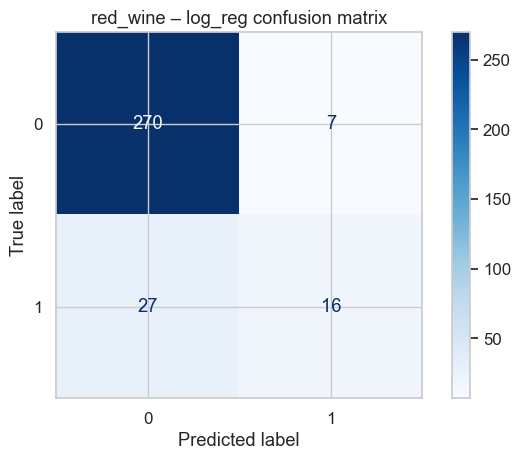


=== red_wine – rf ===
Test Accuracy: 0.9437
Test F1-macro: 0.8592
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       277
           1       0.93      0.63      0.75        43

    accuracy                           0.94       320
   macro avg       0.94      0.81      0.86       320
weighted avg       0.94      0.94      0.94       320



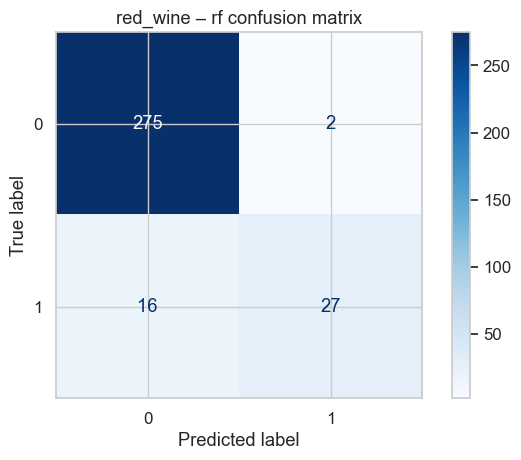


=== wine_dataset – log_reg ===
Test Accuracy: 0.9722
Test F1-macro: 0.9710
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.97        14
           2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



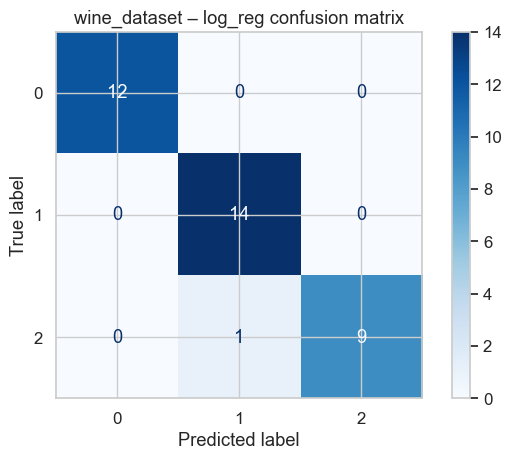


=== wine_dataset – rf ===
Test Accuracy: 1.0000
Test F1-macro: 1.0000
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



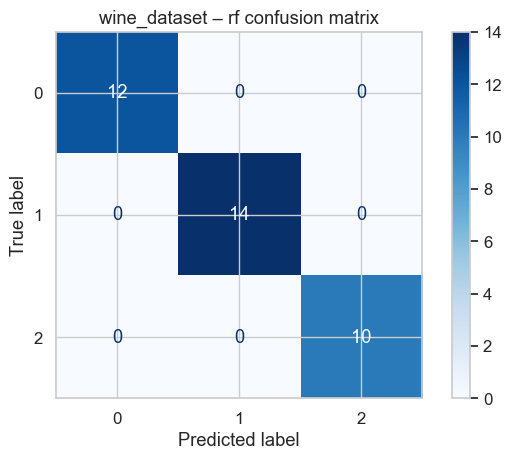

,dataset,model,test_accuracy,test_f1_macro
0,red_wine,log_reg,0.893750,0.712808
1,red_wine,rf,0.943750,0.859155
2,wine_dataset,log_reg,0.972222,0.970962
3,wine_dataset,rf,1.000000,1.000000


In [9]:
# Cell 9: Evaluate tuned models on held-out test sets


def evaluate_on_test_set(grid, X_test, y_test, model_label, dataset_label):
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"\n=== {dataset_label} – {model_label} ===")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1-macro: {f1:.4f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{dataset_label} – {model_label} confusion matrix")
    plt.tight_layout()
    plt.show()

    return {
        "dataset": dataset_label,
        "model": model_label,
        "test_accuracy": acc,
        "test_f1_macro": f1,
    }


test_results = []

# Red wine
for model_name, grid in best_models["red_wine"].items():
    res = evaluate_on_test_set(
        grid, X_red_test, y_red_test, model_label=model_name, dataset_label="red_wine"
    )
    test_results.append(res)

# Wine2 dataset
for model_name, grid in best_models["wine_dataset"].items():
    res = evaluate_on_test_set(
        grid,
        X_wine_test,
        y_wine_test,
        model_label=model_name,
        dataset_label="wine_dataset",
    )
    test_results.append(res)

test_results_df = pd.DataFrame(test_results)
display(test_results_df)

# Save test results
test_results_df.to_csv(
    os.path.join(RESULTS_DIR, "test_results_tuned_models.csv"), index=False
)

## 🔹 Cell 10 – Introduce feature selection (example: SelectKBest)

This is where your research topic (feature selection) starts to enter the experimental pipeline in a **rigorous** way.

We’ll build **two FS pipelines** as examples:

* Logistic Regression + SelectKBest(ANOVA F)
* Random Forest (no FS, as baseline embedded FS)

In [10]:
# Cell 10: Feature selection pipelines (example with SelectKBest)

fs_pipelines = {
    "log_reg_kbest": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("fs", SelectKBest(score_func=f_classif)),
            ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ]
    ),
    # For RF we can compare "all features" vs "top-k based on some criterion" later.
    # For now we keep RF as is and compare against log_reg_kbest.
}

fs_param_grid = {
    "log_reg_kbest": {"fs__k": [3, 5, 7, "all"], "clf__C": [0.1, 1.0, 10.0]}
}

best_fs_models = {"red_wine": {}, "wine_dataset": {}}

for dataset_name, (X_tr, y_tr) in {
    "red_wine": (X_red_train, y_red_train),
    "wine_dataset": (X_wine_train, y_wine_train),
}.items():
    print(f"\n=== Grid Search with Feature Selection for dataset: {dataset_name} ===")

    for model_name, pipe in fs_pipelines.items():
        print(f"\n-> Tuning FS model: {model_name}")

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=fs_param_grid[model_name],
            cv=cv,
            scoring="f1_macro",
            n_jobs=N_JOBS,
            refit=True,
        )

        grid.fit(X_tr, y_tr)

        print("Best params:", grid.best_params_)
        print("Best CV f1_macro:", grid.best_score_)

        best_fs_models[dataset_name][model_name] = grid

# Save FS models
joblib.dump(best_fs_models, os.path.join(MODELS_DIR, "best_fs_models_kbest.pkl"))


=== Grid Search with Feature Selection for dataset: red_wine ===

-> Tuning FS model: log_reg_kbest
Best params: {'clf__C': 10.0, 'fs__k': 'all'}
Best CV f1_macro: 0.6751138852805316

=== Grid Search with Feature Selection for dataset: wine_dataset ===

-> Tuning FS model: log_reg_kbest
Best params: {'clf__C': 1.0, 'fs__k': 'all'}
Best CV f1_macro: 0.9796369712159185


['./models\\best_fs_models_kbest.pkl']

## 🔹 Cell 11 – Compare baseline vs FS on test sets

Now we evaluate FS models on the test sets and **directly compare** with tuned non-FS baselines.

In [11]:
# Cell 11: Compare tuned baselines vs FS models on test sets

comparison_rows = []


# Helper: evaluate FS model and store metrics
def evaluate_fs_vs_baseline(best_models, best_fs_models, X_test, y_test, dataset_label):
    # Baselines
    for model_name, grid in best_models[dataset_label].items():
        y_pred = grid.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        comparison_rows.append(
            {
                "dataset": dataset_label,
                "model_type": "baseline",
                "model_name": model_name,
                "test_accuracy": acc,
                "test_f1_macro": f1,
            }
        )

    # FS models
    for model_name, grid in best_fs_models[dataset_label].items():
        y_pred = grid.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        comparison_rows.append(
            {
                "dataset": dataset_label,
                "model_type": "fs",
                "model_name": model_name,
                "test_accuracy": acc,
                "test_f1_macro": f1,
            }
        )


# Evaluate for both datasets
evaluate_fs_vs_baseline(best_models, best_fs_models, X_red_test, y_red_test, "red_wine")
evaluate_fs_vs_baseline(
    best_models, best_fs_models, X_wine_test, y_wine_test, "wine_dataset"
)

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)

comparison_df.to_csv(
    os.path.join(RESULTS_DIR, "baseline_vs_fs_test_comparison.csv"), index=False
)

,dataset,model_type,model_name,test_accuracy,test_f1_macro
0,red_wine,baseline,log_reg,0.893750,0.712808
1,red_wine,baseline,rf,0.943750,0.859155
2,red_wine,fs,log_reg_kbest,0.893750,0.712808
3,wine_dataset,baseline,log_reg,0.972222,0.970962
4,wine_dataset,baseline,rf,1.000000,1.000000
5,wine_dataset,fs,log_reg_kbest,0.972222,0.970962



## 🔹 Cell 12 – Simple visualization of model performances

This will give you nice plots for your paper.

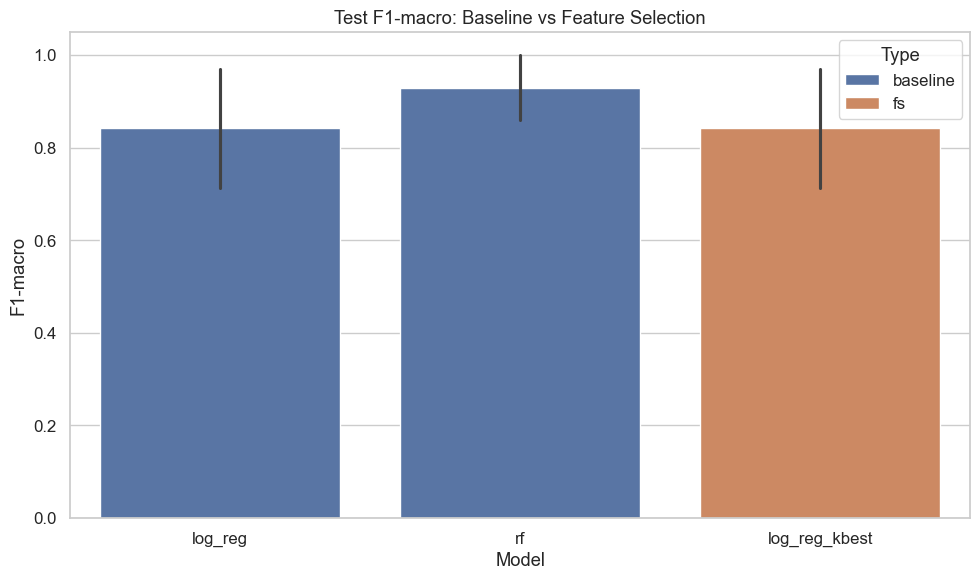

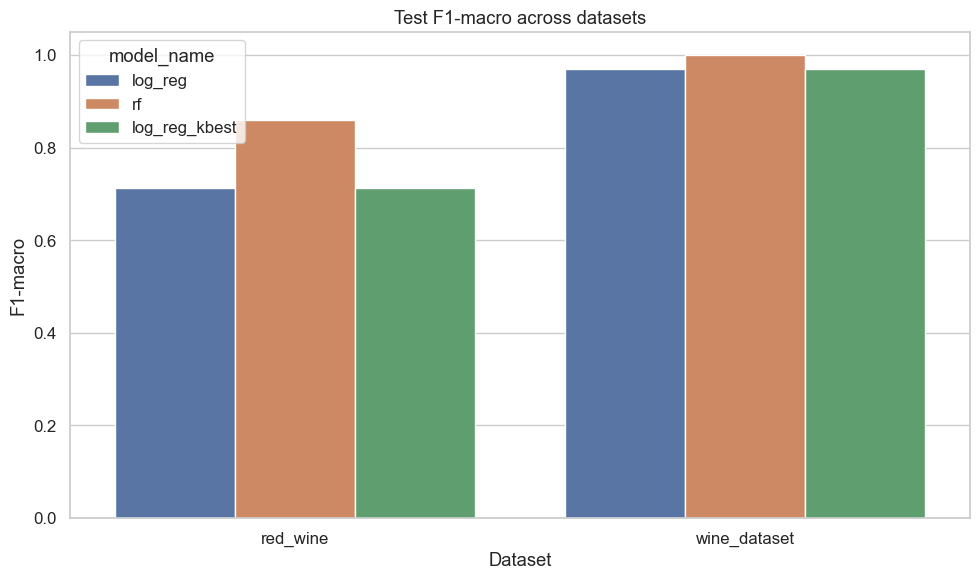

In [12]:
# Cell 12: Visualization of performance comparison

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x="model_name", y="test_f1_macro", hue="model_type")
plt.title("Test F1-macro: Baseline vs Feature Selection")
plt.ylabel("F1-macro")
plt.xlabel("Model")
plt.legend(title="Type")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "f1_macro_baseline_vs_fs.png"))
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x="dataset", y="test_f1_macro", hue="model_name")
plt.title("Test F1-macro across datasets")
plt.ylabel("F1-macro")
plt.xlabel("Dataset")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "f1_macro_by_dataset.png"))
plt.show()

## 🔹 Cell 13 – Save final best models separately

This is important for reproducibility and reuse.

In [13]:
# Cell 13: Save individual best models (optional but good practice)

# Example: save best red wine models
for model_name, grid in best_models["red_wine"].items():
    model_path = os.path.join(MODELS_DIR, f"red_wine_best_{model_name}.joblib")
    joblib.dump(grid.best_estimator_, model_path)

for model_name, grid in best_fs_models["red_wine"].items():
    model_path = os.path.join(MODELS_DIR, f"red_wine_best_fs_{model_name}.joblib")
    joblib.dump(grid.best_estimator_, model_path)

# Same for wine_dataset
for model_name, grid in best_models["wine_dataset"].items():
    model_path = os.path.join(MODELS_DIR, f"wine_dataset_best_{model_name}.joblib")
    joblib.dump(grid.best_estimator_, model_path)

for model_name, grid in best_fs_models["wine_dataset"].items():
    model_path = os.path.join(MODELS_DIR, f"wine_dataset_best_fs_{model_name}.joblib")
    joblib.dump(grid.best_estimator_, model_path)

## 🔹 Cell 14 - Results

In [14]:
baseline_df = pd.read_csv("./results/baseline_cv_results.csv")
baseline_df.head(10).T

,0,1,2,3
dataset,red_wine,wine_dataset,red_wine,wine_dataset
model,log_reg,log_reg,rf,rf
accuracy_mean,0.878799,0.979064,0.888174,0.979064
accuracy_std,0.009426,0.027713,0.016662,0.027713
f1_macro_mean,0.673923,0.979637,0.707426,0.978923
f1_macro_std,0.020821,0.027283,0.049961,0.028548


In [15]:
baseline_vs_fs_test_comparison_df = pd.read_csv(
    "./results/baseline_vs_fs_test_comparison.csv"
)
baseline_vs_fs_test_comparison_df.head(10).T

,0,1,2,3,4,5
dataset,red_wine,red_wine,red_wine,wine_dataset,wine_dataset,wine_dataset
model_type,baseline,baseline,fs,baseline,baseline,fs
model_name,log_reg,rf,log_reg_kbest,log_reg,rf,log_reg_kbest
test_accuracy,0.89375,0.94375,0.89375,0.972222,1.0,0.972222
test_f1_macro,0.712808,0.859155,0.712808,0.970962,1.0,0.970962


In [16]:
test_results_tuned_models_df = pd.read_csv(
    "./results/test_results_tuned_models.csv"
)
test_results_tuned_models_df.head(10).T

,0,1,2,3
dataset,red_wine,red_wine,wine_dataset,wine_dataset
model,log_reg,rf,log_reg,rf
test_accuracy,0.89375,0.94375,0.972222,1.0
test_f1_macro,0.712808,0.859155,0.970962,1.0
